<a href="https://colab.research.google.com/github/SVJLucas/DeepLense/blob/main/CreatingDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Dataset

In [ ]:
!wget https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5 -O Galaxy10_DECals.h5 --no-check-certificate

--2023-09-22 11:12:28--  https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 142.1.217.162
Connecting to astro.utoronto.ca (astro.utoronto.ca)|142.1.217.162|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5 [following]
--2023-09-22 11:12:28--  https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G)
Saving to: ‘Galaxy10_DECals.h5’

Galaxy10_DECals.h5  100%[===================>]   2.55G  87.9MB/s    in 30s     

2023-09-22 11:12:58 (87.0 MB/s) - ‘Galaxy10_DECals.h5’ saved [2735267419/2735267419]



# Installing Libraries

In [ ]:
!pip install lenstronomy
!pip install pyHalo
!pip install colossus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
  Created wheel for lenstronomy: filename=lenstronomy-1.11.3-py3-none-any.whl size=1137335 sha256=61c263fbd709129412e277d7044f06c15ae8147c686f7a6d8fda4048431d74bc
  Stored in directory: /root/.cache/pip/wheels/5c/eb/d3/730a5c48efd0000c423da86bf917195f19d69d4b55acdaf025
  Created wheel for schwimmbad: filename=schwimmbad-0.3.2-py3-none-any.whl size=15729 sha256=183c1b8c38d90e2a7a3e4a84d912d436f9189797945a6d877b43394fa38a0f2e
  Stored in directory: /root/.cache/pip/wheels/4a/ea/3e/b79646d96eaea548b8e

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.0/205.0 kB 3.8 MB/s eta 0:00:00


# Importing Libraries

In [ ]:
from tqdm import tqdm


import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import random

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()



# Define a specific cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# Instrument setting from pre-defined configurations
from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid

Euclid_g = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_g_band = Euclid_g.kwargs_single_band()
Euclid_r = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_r_band = Euclid_r.kwargs_single_band()
Euclid_i = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_i_band = Euclid_i.kwargs_single_band()

from pyHalo.preset_models import CDM
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.single_realization import SingleHalo

from lenstronomy.LensModel.Profiles.cnfw import CNFW
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

# Opening the dataset

In [ ]:
################################################
######### Load real galaxies
################################################
# To get the images and labels from file
with h5py.File('/content/Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    typ = np.array(F['ans'])
    z = np.array(F['redshift'])

unbarred_spiral = np.where(typ == 6)
images_ref = images[unbarred_spiral]
z_ref = z[unbarred_spiral]

indx_img_zp1 = np.where(z_ref < 0.02)
img_zp1 = images_ref[indx_img_zp1]
# good galaxies, checked by eye
arr = [2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,54,55]
#################################################

# Defining Simulation Functions

## No-sub

In [ ]:
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import random

from scipy.ndimage import gaussian_filter

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()

# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

# Instrument setting from pre-defined configurations
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
#LSST_g = HST(band='WFC3_F160W', psf_type='GAUSSIAN')#, coadd_years=10)
#kwargs_g_band = LSST_g.kwargs_single_band()

from pyHalo.preset_models import ULDM
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.single_realization import SingleHalo

from lenstronomy.LensModel.Profiles.cnfw import CNFW
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions


#Tailored individual settings (as an example):

"""
LSST_camera = {'read_noise': 10,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.05,  # scale (in arcseonds) of pixels
               'ccd_gain': 4.5  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

LSST_g_band_obs = {'exposure_time': 60.,  # exposure time per image (in seconds)
                   'sky_brightness': 20.0,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 1,  # number of exposures that are combined
                   'seeing': 0.012,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

# here we merge observations and instrument for the three bands
kwargs_g_band = util.merge_dicts(LSST_camera, LSST_g_band_obs)
"""

"""
# Instrument setting from pre-defined configurations
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
LSST_g = HST(band='WFC3_F160W', psf_type='GAUSSIAN')#, coadd_years=10)
kwargs_g_band = LSST_g.kwargs_single_band()
LSST_r = HST(band='WFC3_F160W', psf_type='GAUSSIAN')#, coadd_years=10)
kwargs_r_band = LSST_r.kwargs_single_band()
LSST_i = HST(band='WFC3_F160W', psf_type='GAUSSIAN')#, coadd_years=10)
kwargs_i_band = LSST_i.kwargs_single_band()
"""

from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid

Euclid_g = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_g_band = Euclid_g.kwargs_single_band()
Euclid_r = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_r_band = Euclid_r.kwargs_single_band()
Euclid_i = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_i_band = Euclid_i.kwargs_single_band()


def simulate_no_sub(image_galaxy,axion_mass,Ens,source_pos_xx,source_pos_yy,source_ang,zlens=0.5,zsource=1.0):

    #######################################################################

    # pyHalo inputs to generate single ULDM halos
    axion_mass = -21.5

    profile_arg = {'log10_m_uldm': axion_mass,
                     'uldm_plaw': 1/3,
                     'scale_nfw':False,
                     'evaluate_mc_at_zlens':True,
                     'c_scatter':False}

    # define the lens model of the main deflector
    main_halo_type = 'SIE'  # You have many other possibilities available. Check out the SinglePlane class!
    kwargs_lens_main = {'theta_E': Ens, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0.}
    kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
    lens_model_macro = [main_halo_type, 'SHEAR']
    kwargs_lens = [kwargs_lens_main, kwargs_shear]


    log10_m_uldms, uldm_plaw, scale_nfw = axion_mass, 1/3, False  #Pq esses valores?

    #realizationsULDM = ULDM(zlens, zsource, log10_m_uldm=log10_m_uldms, uldm_plaw=uldm_plaw, scale_nfw=scale_nfw) #Original
    realizationsULDM = ULDM(zlens, zsource, log10_m_uldm=log10_m_uldms, uldm_plaw=uldm_plaw, flucs=scale_nfw)

    # print(r'ULDM realization with log(m)=%s contains %s halos'
    #          % (log10_m_uldms, len(realizationsULDM.halos)))


    #lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationsULDM.lensing_quantities()
    astropy_instance = realizationsULDM.astropy_instance

    # cored halo + shear macromodel
    kwargs_macromodel = kwargs_lens

    lens_model_list_macro = lens_model_macro #[main_halo_type, 'SHEAR']#['CNFW','ULDM', 'SHEAR']

    lens_model_list_full = lens_model_list_macro #+ lens_model_list
    lens_redshift_list_full = [zlens, zlens] #+ list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel #+ kwargs_halos
    kwargs_lens_list = kwargs_lens_full

    kwargs_lens = kwargs_lens_full

###############################################################################

    kwargs_model_physical = {'lens_model_list': lens_model_list_full,  # list of lens models to be used
                              'lens_redshift_list': lens_redshift_list_full,  # list of redshift of the deflections
                              'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                              'source_light_model_list': ['INTERPOL'],  # list of extended source models to be used
                              'source_redshift_list': [1.0],  # list of redshfits of the sources in same order as source_light_model_list
                              'cosmo': astropy_instance,  # astropy.cosmology instance
                              'z_source_convention': 2.5,  # source redshfit to which the reduced deflections are computed, is the maximal redshift of the ray-tracing
                              'z_source': 2.5,}  # redshift of the default source (if not further specified by 'source_redshift_list') and also serves as the redshift of lensed point sources

    #kwargs_mass = [{'sigma_v': sigma_v, 'center_x': 0, 'center_y': 0, 'e1': 0.0, 'e2': 0}]

    kwargs_model_postit = kwargs_model_physical




    ##########################################JOSEPH############################

    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                              'lens_redshift_list': [0.5],  # list of redshift of the deflections
                              'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                              'source_light_model_list': ['INTERPOL'],  # list of extended source models to be used
                              'source_redshift_list': [1.0],  # list of redshfits of the sources in same order as source_light_model_list
                              'cosmo': cosmo,  # astropy.cosmology instance
                              'z_source_convention': 2.5,  # source redshfit to which the reduced deflections are computed, is the maximal redshift of the ray-tracing
                              'z_source': 2.5,}  # redshift of the default source (if not further specified by 'source_redshift_list') and also serves as the redshift of lensed point sources

    sigma_v = np.random.normal(260,20)
    kwargs_mass = [{'sigma_v': sigma_v, 'center_x': 0, 'center_y': 0, 'e1': 0.0, 'e2': 0}]

    kwargs_model_postit = kwargs_model_physical

    #######################################################################
    numpix = 64  # number of pixels per axis of the image to be modelled

    # here we define the numerical options used in the ImSim module.
    # Have a look at the ImageNumerics class for detailed descriptions.
    # If not further specified, the default settings are used.
    kwargs_numerics = {'point_source_supersampling_factor': 1}




    ###############################JOSEPH########################################




    #######################################################################
    numpix = 64  # number of pixels per axis of the image to be modelled

    # here we define the numerical options used in the ImSim module.
    # Have a look at the ImageNumerics class for detailed descriptions.
    # If not further specified, the default settings are used.
    kwargs_numerics = {'point_source_supersampling_factor': 1}


    #######################################################################
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_postit)

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_g = sim_g.image_model_class(kwargs_numerics)

    source_scale = 0.015#25

    X,Y = source_pos_xx, source_pos_yy

    # g-band
    # lens light
    image_data_g = image_galaxy.astype(float)
    median_g = np.median(image_galaxy[:50, :50].astype(float))
    image_data_g -= median_g

    #kwargs_lens_light_mag_g = [{'magnitude': 16, 'image': image_gauss, 'scale': lens_scale, 'phi_G': 0, 'center_x': 0., 'center_y': 0}]
    # lens light
    kwargs_lens_light_mag_g = [{'magnitude':40, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
    {'magnitude': 40, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}]
    kwargs_source_mag_g = [{'magnitude': np.random.normal(16,.1), 'image': image_data_g, 'scale': source_scale, 'phi_G': source_ang, 'center_x': X, 'center_y': Y}]

    # and now we define the colors of the other two bands

    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_g, kwargs_source_g,_ = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)

    #added then removed by me
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)

    # add noise
    image_g += sim_g.noise_for_model(model=image_g)

    # save to output
    #img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
    #img[:,:,0] = image_g#plot_util.sqrt(image_g, scale_min=0, scale_max=100)

    return image_g, realizationsULDM


#number_of_sims = int(2.5e4)

def simulator_model_no_sub(parameter,img_zp1,return_points=False):

    index = np.random.randint(0,len(img_zp1))

    Ens,source_pos_xx,source_pos_yy, source_ang = np.random.normal(1.5,.5), np.random.uniform(-0.4,0.4), np.random.uniform(-0.4,0.4), np.random.uniform(-np.pi,np.pi)

    # Calculate the 2d mask
    x = np.linspace(-128, 128, 256)
    y = np.linspace(-128, 128, 256)

    # Convolve galaxy with a Gaussian filter to remove some noise
    result = gaussian_filter(img_zp1[index][:,:,0], sigma=3)

    """
    # Fit two Gaussians to the image compressed down the x and y axis. This will serve to infer the filter we will use.
    axis_0 = np.sum(result,axis=0)
    axis_0 = axis_0/np.max(axis_0)
    axis_1 = np.sum(result,axis=1)
    axis_1 = axis_1/np.max(axis_1)

    # Fit the Gaussians
    popt_0, pcov_0 = curve_fit(Gauss, x, axis_0, p0=[np.min(axis_0), np.max(axis_0), 0, 30], bounds=([0.,0.,-10.,10.], [1., 1.,10.,40]))
    popt_1, pcov_1 = curve_fit(Gauss, y, axis_1, p0=[np.min(axis_1), np.max(axis_1), 0, 30], bounds=([0.,0.,-10.,10.], [1., 1.,10.,40]))
    _,_,mu_0,std_0 = popt_0
    _,_,mu_1,std_1 = popt_1
    """
    mx, my, sx, sy = 0, 0, 25, 25

    # full coorindate arrays
    xx, yy = np.meshgrid(x, y)
    zz = gaus2d(x=xx,y=yy,mx=mx, my=my,sx=sx, sy=sy)

    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(result)
    plt.subplot(1,2,2)
    plt.imshow(zz*result)
    plt.show()"""

    sim, realizationsULDM = simulate_no_sub(result,parameter,Ens,source_pos_xx,source_pos_yy,source_ang)

    """
    plt.figure(figsize=(6,6))
    plt.imshow(sim)
    plt.show()"""

    # fix this, just temp fix to be between 0,1
    return np.absolute(sim), parameter, zz*result, result

def simulate_image_no_sub(img_zp1):
  amass = -21.5
  sim, mass, mask, orig = simulator_model_no_sub(amass,img_zp1)
  return np.array(sim).clip(min=0)


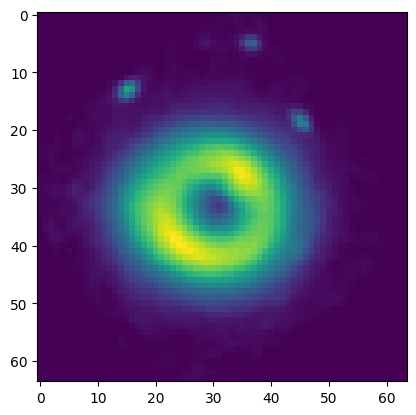

In [ ]:
plt.imshow(simulate_image_no_sub(img_zp1),cmap='inferno')

## CDM

In [ ]:
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import random

from scipy.ndimage import gaussian_filter

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()

# define normalized 2D gaussian
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

# Instrument setting from pre-defined configurations
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
#LSST_g = HST(band='WFC3_F160W', psf_type='GAUSSIAN')#, coadd_years=10)
#kwargs_g_band = LSST_g.kwargs_single_band()

from pyHalo.preset_models import CDM
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.single_realization import SingleHalo

from lenstronomy.LensModel.Profiles.cnfw import CNFW
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions


#Tailored individual settings (as an example):

"""
LSST_camera = {'read_noise': 10,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.05,  # scale (in arcseonds) of pixels
               'ccd_gain': 4.5  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

LSST_g_band_obs = {'exposure_time': 60.,  # exposure time per image (in seconds)
                   'sky_brightness': 20.0,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 1,  # number of exposures that are combined
                   'seeing': 0.012,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

# here we merge observations and instrument for the three bands
kwargs_g_band = util.merge_dicts(LSST_camera, LSST_g_band_obs)
"""

"""
# Instrument setting from pre-defined configurations
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
LSST_g = HST(band='WFC3_F160W', psf_type='GAUSSIAN')#, coadd_years=10)
kwargs_g_band = LSST_g.kwargs_single_band()
LSST_r = HST(band='WFC3_F160W', psf_type='GAUSSIAN')#, coadd_years=10)
kwargs_r_band = LSST_r.kwargs_single_band()
LSST_i = HST(band='WFC3_F160W', psf_type='GAUSSIAN')#, coadd_years=10)
kwargs_i_band = LSST_i.kwargs_single_band()
"""

from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid

Euclid_g = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_g_band = Euclid_g.kwargs_single_band()
Euclid_r = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_r_band = Euclid_r.kwargs_single_band()
Euclid_i = Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6)
kwargs_i_band = Euclid_i.kwargs_single_band()


def simulate_cdm(image_galaxy,Ens,source_pos_xx,source_pos_yy,source_ang,zlens=0.5,zsource=1.0):

    #######################################################################

    # pyHalo inputs to generate single ULDM halos
    #axion_mass = -21

    #profile_arg = {'log10_m_uldm': axion_mass,
    #                 'uldm_plaw': 1/3,
    #                 'scale_nfw':False,
    #                 'evaluate_mc_at_zlens':True,
    #                 'c_scatter':False}

    # define the lens model of the main deflector
    main_halo_type = 'SIE'  # You have many other possibilities available. Check out the SinglePlane class!
    kwargs_lens_main = {'theta_E': Ens, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0.}
    kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
    lens_model_macro = [main_halo_type, 'SHEAR']
    kwargs_lens = [kwargs_lens_main, kwargs_shear]


    realizationsCDM = CDM(zlens, zsource,cone_opening_angle_arcsec=10)

    # print(r'CDM realization contains %s halos'
    #           % (len(realizationsCDM.halos)))


    lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationsCDM.lensing_quantities()
    astropy_instance = realizationsCDM.astropy_instance

    # cored halo + shear macromodel
    kwargs_macromodel = kwargs_lens

    lens_model_list_macro = lens_model_macro #[main_halo_type, 'SHEAR']#['CNFW','ULDM', 'SHEAR']

    lens_model_list_full = lens_model_list_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos
    kwargs_lens_list = kwargs_lens_full

    kwargs_lens = kwargs_lens_full

###############################################################################

    kwargs_model_physical = {'lens_model_list': lens_model_list_full,  # list of lens models to be used
                              'lens_redshift_list': lens_redshift_list_full,  # list of redshift of the deflections
                              'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                              'source_light_model_list': ['INTERPOL'],  # list of extended source models to be used
                              'source_redshift_list': [1.0],  # list of redshfits of the sources in same order as source_light_model_list
                              'cosmo': astropy_instance,  # astropy.cosmology instance
                              'z_source_convention': 2.5,  # source redshfit to which the reduced deflections are computed, is the maximal redshift of the ray-tracing
                              'z_source': 2.5,}  # redshift of the default source (if not further specified by 'source_redshift_list') and also serves as the redshift of lensed point sources

    #kwargs_mass = [{'sigma_v': sigma_v, 'center_x': 0, 'center_y': 0, 'e1': 0.0, 'e2': 0}]

    kwargs_model_postit = kwargs_model_physical


    #######################################################################
    numpix = 64  # number of pixels per axis of the image to be modelled

    # here we define the numerical options used in the ImSim module.
    # Have a look at the ImageNumerics class for detailed descriptions.
    # If not further specified, the default settings are used.
    kwargs_numerics = {'point_source_supersampling_factor': 1}


    #######################################################################
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_postit)

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_g = sim_g.image_model_class(kwargs_numerics)

    source_scale = 0.015#25

    X,Y = source_pos_xx, source_pos_yy

    # g-band
    # lens light
    image_data_g = image_galaxy.astype(float)
    median_g = np.median(image_galaxy[:50, :50].astype(float))
    image_data_g -= median_g

    #kwargs_lens_light_mag_g = [{'magnitude': 16, 'image': image_gauss, 'scale': lens_scale, 'phi_G': 0, 'center_x': 0., 'center_y': 0}]
    # lens light
    kwargs_lens_light_mag_g = [{'magnitude':40, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
    {'magnitude': 40, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}]
    kwargs_source_mag_g = [{'magnitude': np.random.normal(16,0.1), 'image': image_data_g, 'scale': source_scale, 'phi_G': source_ang, 'center_x': X, 'center_y': Y}]

    # and now we define the colors of the other two bands

    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_g, kwargs_source_g,_ = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)

    #added then removed by me
    #kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)

    # add noise
    image_g += sim_g.noise_for_model(model=image_g)

    # save to output
    #img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
    #img[:,:,0] = image_g#plot_util.sqrt(image_g, scale_min=0, scale_max=100)

    return image_g, realizationsCDM


def simulator_model_cdm(img_zp1,return_points=False):

    index = np.random.randint(0,len(img_zp1))

    Ens,source_pos_xx,source_pos_yy, source_ang = np.random.normal(1.5,.5), np.random.uniform(-0.4,0.4), np.random.uniform(-0.4,0.4), np.random.uniform(-np.pi,np.pi)

    # Calculate the 2d mask
    x = np.linspace(-128, 128, 256)
    y = np.linspace(-128, 128, 256)

    # Convolve galaxy with a Gaussian filter to remove some noise
    result = gaussian_filter(img_zp1[index][:,:,0], sigma=3)

    """
    # Fit two Gaussians to the image compressed down the x and y axis. This will serve to infer the filter we will use.
    axis_0 = np.sum(result,axis=0)
    axis_0 = axis_0/np.max(axis_0)
    axis_1 = np.sum(result,axis=1)
    axis_1 = axis_1/np.max(axis_1)

    # Fit the Gaussians
    popt_0, pcov_0 = curve_fit(Gauss, x, axis_0, p0=[np.min(axis_0), np.max(axis_0), 0, 30], bounds=([0.,0.,-10.,10.], [1., 1.,10.,40]))
    popt_1, pcov_1 = curve_fit(Gauss, y, axis_1, p0=[np.min(axis_1), np.max(axis_1), 0, 30], bounds=([0.,0.,-10.,10.], [1., 1.,10.,40]))
    _,_,mu_0,std_0 = popt_0
    _,_,mu_1,std_1 = popt_1
    """
    mx, my, sx, sy = 0, 0, 25, 25

    # full coorindate arrays
    xx, yy = np.meshgrid(x, y)
    zz = gaus2d(x=xx,y=yy,mx=mx, my=my,sx=sx, sy=sy)

    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(result)
    plt.subplot(1,2,2)
    plt.imshow(zz*result)
    plt.show()"""

    sim, realizationsCDM = simulate_cdm(result,Ens,source_pos_xx,source_pos_yy,source_ang)



    """
    plt.figure(figsize=(6,6))
    plt.imshow(sim)
    plt.show()"""

    # fix this, just temp fix to be between 0,1
    return np.absolute(sim), zz*result, result

def simulate_image_cdm(img_zp1):
    sim, mask, orig = simulator_model_cdm(img_zp1)
    return np.array(sim).clip(min=0)

In [ ]:
images_ref = images
z_ref = z
indx_img_zp1 = np.where(z_ref < 1)
img_zp1 = images_ref[indx_img_zp1]

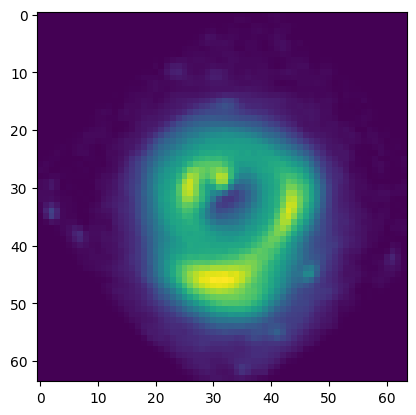

In [ ]:
plt.imshow(simulate_image_cdm(img_zp1),cmap='inferno')

# Creating dataset

Run the Cells bellow to generate the dataset without ULDM interface:

In [ ]:
data = []
labels = []

In [ ]:
data_path = '../data/Real-Galaxy-Tiny Dataset'

In [ ]:
def save_list_as_numpy_array(lst, path):
    """
    Save a list as a numpy array to the given path.

    Args:
        lst (list): The list to be saved.
        path (str): The path where the numpy array should be saved.

    Returns:
        None
    """
    np_array = np.array(lst)
    np.save(path, np_array)

In [ ]:
from IPython.display import clear_output

for kind in ('train','test'):
  for i in tqdm(range(500)):

      no_sub = simulate_image_no_sub(img_zp1)
      no_sub = no_sub/np.max(no_sub)

      cdm = simulate_image_cdm(img_zp1)
      cdm = cdm/np.max(cdm)

      data.append(no_sub.reshape(64,64))
      labels.append([1,0])
      data.append(cdm.reshape(64,64))
      labels.append([0,1])

      if i%10==0:
        save_list_as_numpy_array(data,f'{data_path}/data_{kind}.npy')
        save_list_as_numpy_array(labels,f'{data_path}/labels_{kind}.npy')

  save_list_as_numpy_array(data,f'{data_path}/data_{kind}.npy')
  save_list_as_numpy_array(labels,f'{data_path}/labels_{kind}.npy')
  clear_output()

100%|██████████| 500/500 [3:30:45<00:00, 25.29s/it]
